In this notebook we create 2 groups of neurons:

first group consists of uncoupled neurons;

second group consists of coupled neurons with the same post-spike filter.

In [42]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import random
%matplotlib inline

In [43]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(),".."))
sys.path.append(os.path.join(os.getcwd(),"..","code"))

In [44]:
import filters
import likelihood_functions as lk
import PoissonProcessClasses as PP
import auxiliary_functions as auxfun

In [45]:
# Reloading modules which are in development
import imp
imp.reload(filters)
imp.reload(auxfun)
imp.reload(lk)
imp.reload(PP)

<module 'PoissonProcessClasses' from '/Users/val/MEGAsync/GLM_PythonModules/notebooks/../code/PoissonProcessClasses.py'>

In [46]:
dt = 0.01

In [47]:
# create a stimulus filter
kpeaks = np.array([0,round(20/3)])
pars_k = {'neye':5,'n':5,'kpeaks':kpeaks,'b':3}
K,K_orth,kt_domain = filters.createStimulusBasis(pars_k, nkt = 20) 

In [48]:
# create a post-spike filter
hpeaks = np.array([0.1,2])
pars_h = {'n':5,'hpeaks':hpeaks,'b':.4,'absref':0.}
H,H_orth,ht_domain = filters.createPostSpikeBasis(pars_h,dt)

In [49]:
Stim = np.round(sp.rand(2500)*4-2);

In [50]:
M_k = lk.construct_M_k(Stim,K,dt)

In [51]:
M = np.hstack((M_k,np.ones((M_k.shape[0],1))))

In [52]:
coeff_k = np.array([ 0.061453,0.284916,0.860335,1.256983,0.910615,0.488660,-0.887091,0.097441,0.026607,-0.090147])
coeff_h = np.array([-10, -5, 0, 2, -2])

In [53]:
N = 10 # needs to be an even number
a = np.hstack(tuple([coeff_h]*np.int(N/2)+[np.zeros(coeff_h.shape)]*np.int(N/2)))

In [54]:
coeff_list = [np.hstack((coeff_k,3,a))]*np.int(N/2)+[np.hstack((coeff_k,3,np.zeros((N*H.shape[1],))))]*np.int(N/2)

In [55]:
tsp_sim = auxfun.simSpikesMultiple(coeff_list,M,H,ht_domain,dt = 0.01)

spike0
spike94
spike102
spike133
spike198
spike256
spike320
spike362
spike366
spike388
spike408
spike419
spike429
spike453
spike455
spike476
spike507
spike523
spike599
spike617
spike628
spike629
spike660
spike673
spike702
spike744
spike767
spike778
spike791
spike792
spike821
spike827
spike832
spike837
spike846
spike866
spike879
spike888
spike897
spike904
spike935
spike988
spike1219
spike1334
spike1669
spike1736
spike1822
spike2184
spike2274
spike2298
spike2305
spike2306
spike2380
spike2387
spike2400
spike2404
spike2474
spike2487
spike2536
spike2573
spike2606
spike2627
spike2666
spike2673
spike2678
spike2700
spike2855
spike2983
spike3158
spike3210
spike3214
spike3251
spike3263
spike3268
spike3269
spike3295
spike3363
spike3376
spike3387
spike3655
spike3692
spike3724
spike3744
spike3746
spike3750
spike3755
spike3757
spike3768
spike3771
spike3773
spike3779
spike3780
spike3782
spike3783
spike3784
spike3785
spike3788
spike3790
spike3791
spike3793
spike3794
spike3798
spike3803
spike3806
spike

In [56]:
import matplotlib.cm as cm
colors = cm.hot(np.linspace(0,1,len(tsp_sim)))

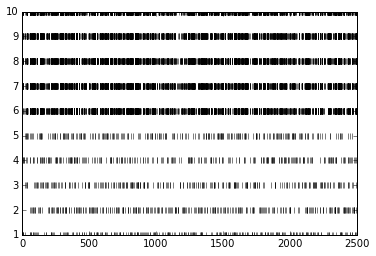

In [57]:
plt.hold(True)
for i in range(len(tsp_sim)):
    plt.plot(tsp_sim[i],[(i+1)]*len(tsp_sim[i]),'k|')

In [58]:
# make estimation work on a list of lists: for tsp_sim
# I think it currently works on a list of np.array
# need to create a function to convert tsps to spike trains

In [59]:
dt = 0.01
y_list = []
for tsp in tsp_sim:
    tsp = np.array(tsp).astype(np.float)
    tsp_int = np.ceil((tsp - dt*0.001)/dt)
    tsp_int = np.reshape(tsp_int,(tsp_int.shape[0],1))
    tsp_int = tsp_int.astype(int)
    y_list.append(np.array([item in tsp_int for item in np.arange(Stim.shape[0]/dt)+1]).astype(int))

In [60]:
tsp_list = tsp_sim

In [62]:
# Interpolate Post Spike Filter
MSP = auxfun.makeInterpMatrix(len(ht_domain),1)
MSP[0,0] = 0
H_orth = np.dot(MSP,H_orth)

In [63]:
# creating a H-matrix for each response and merging them in one covariate matrix M_h
M_h_list = []
for tsp in tsp_list:
    tsp = np.array(tsp).astype(np.float)
    M_h_list.append(lk.construct_M_h(tsp,H_orth,dt,Stim))
    

#M_h_list[1] = np.zeros(M_h_list[0].shape)
M_h = np.hstack(tuple(M_h_list))

In [64]:
# combining all covariate matrices
M = np.hstack((M_k,M_h,np.ones((M_h.shape[0],1))))

In [65]:
model = PP.PPModel(M.T,dt = dt/100)

In [66]:
pars0 = np.zeros((M.shape[1],))

In [67]:
res_list = []
for y in y_list:
    print('Initial likelihood is '+str(model.negLogL(pars0,y)))
    res_list.append(model.fit(y,start_coef = pars0, maxiter = 500, method = 'L-BFGS-B'))

25.0
Initial likelihood is 25.0
25.0
525869.444866
-119.898364164
4160015.65868
-49.0036559699
-189.829929014
444.262408251
-279.306015
-357.767467593
-399.698600311
-415.558024433
-436.996146304
-459.519605269
-471.301633041
-475.381223734
-479.070762497
-481.816001795
-484.763526069
-486.482068356
-487.500193083
-489.208196934
-491.395693371
-494.087222357
-497.318197232
-498.651493939
-499.700691299
-500.315028862
-500.905320194
-501.836853402
-504.551465066
-508.976585586
-514.428408442
-516.27242128
-519.449510314
-520.780684658
-522.138860999
-525.01720304
-529.342761809
-535.520765364
-541.149482257
-551.617648925
-560.057515051
-570.783548256
-584.506593019
-596.664343922
-614.893181777
-626.54707848
-633.666187938
-638.774424318
-643.259876589
-645.487535681
-648.28621955
-650.068075771
-655.027934775
-664.415481088
-667.242908306
-682.674620823
-686.127353245
-687.461490813
-690.159311254
-691.437947592
-694.94537261
-698.121061888
-678.456975873
-699.957118257
-703.905765844

/Users/val/MEGAsync/GLM_PythonModules/notebooks/../code/PoissonProcessClasses.py:171: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if start_coef==None:
/Users/val/anaconda/lib/python3.4/site-packages/scipy/optimize/_minimize.py:362: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  RuntimeWarning)
/Users/val/MEGAsync/GLM_PythonModules/notebooks/../code/PoissonProcessClasses.py:173: OptimizeWarning: Unknown solver options: maxfev
  res = optimize.minimize(self.negLogL,start_coef,jac = self.gradNegLogL,hess = self.hessNegLogL, args = y, options = opts, method = method)


In [68]:
res_list

[    nfev: 541
     jac: array([ 0.25483239, -0.60103469, -0.06704077, -0.09488907,  0.11283313,
       -0.26923054,  0.0897736 , -0.09851031, -0.10722184,  0.27382783,
       -0.01176188, -0.01508213, -0.00247386,  0.02831595, -0.00430761,
       -0.02407874,  0.00838404,  0.0188233 ,  0.03812855, -0.0234982 ,
        0.02078904, -0.0389716 , -0.00265081,  0.04878811,  0.02564788,
       -0.01628062, -0.01617513,  0.02104321,  0.04348607, -0.01709292,
       -0.05641847,  0.07037023,  0.06267855,  0.05971906, -0.05100866,
       -0.17610552, -0.08960573, -0.19330362, -0.04922449, -0.14778974,
       -0.09046986, -0.32342499, -0.18482636,  0.07059404, -0.02902676,
       -0.01287077, -0.13910417, -0.05424056,  0.02704244, -0.11338464,
       -0.21005695, -0.19291359, -0.12799278, -0.10054035,  0.13071497,
       -0.24171547, -0.42911269,  0.00720801, -0.08150552, -0.02444069,
        0.08877212])
     nit: 501
  status: 1
     fun: -827.7192589039355
 message: b'STOP: TOTAL NO. of ITER

In [69]:
k_coeff = coeff_k
h_coeff = coeff_h

Estimated dc for neuron 0: 3.05702847452
Estimated dc for neuron 1: 3.04408921825
Estimated dc for neuron 2: 3.05694330844
Estimated dc for neuron 3: 3.0430744985
Estimated dc for neuron 4: 2.79792025588
Estimated dc for neuron 5: 2.86375184595
Estimated dc for neuron 6: 2.9590455265
Estimated dc for neuron 7: 3.01538115027
Estimated dc for neuron 8: 2.8699089826
Estimated dc for neuron 9: 2.76755680371


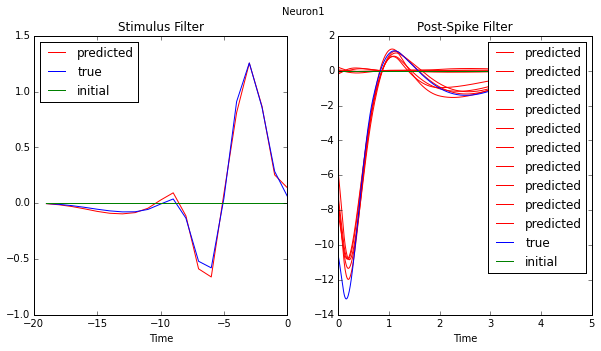

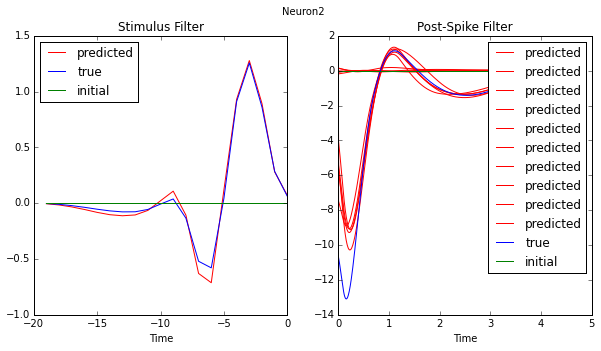

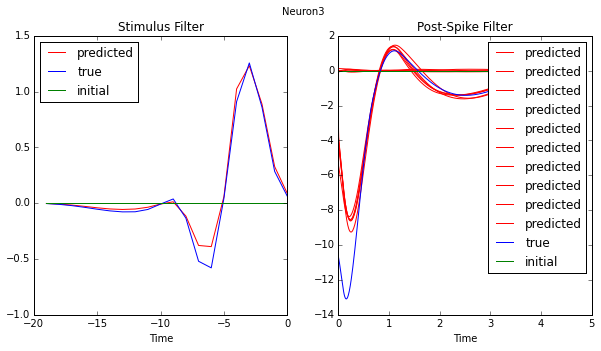

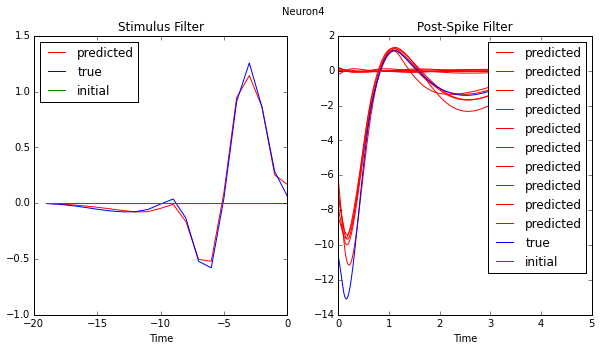

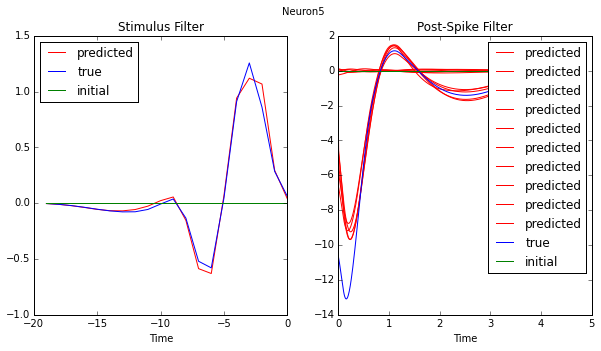

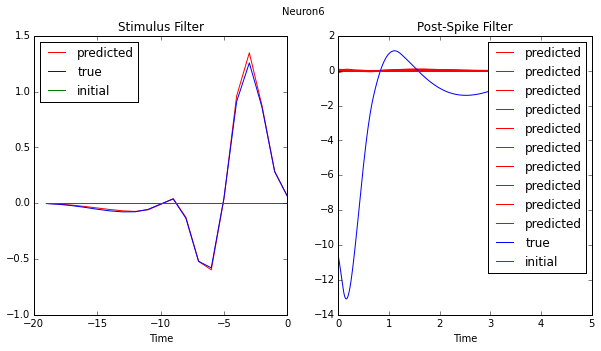

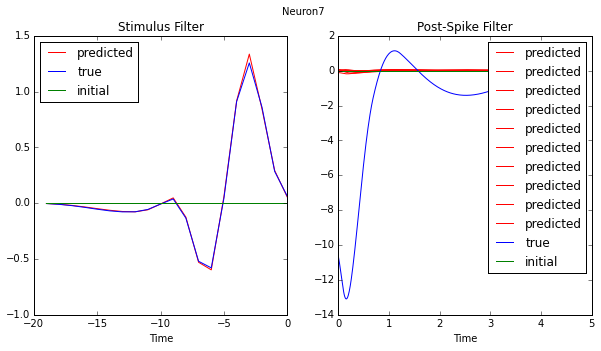

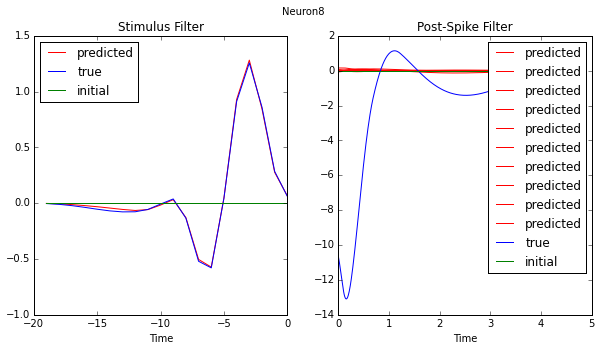

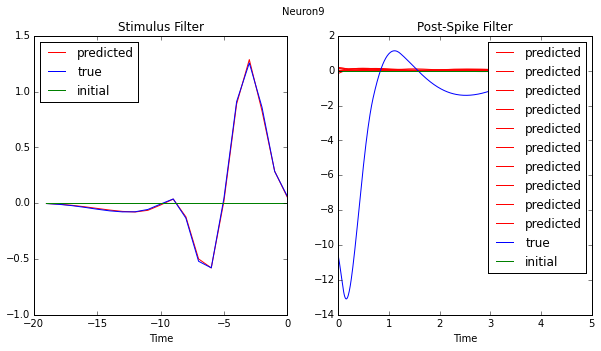

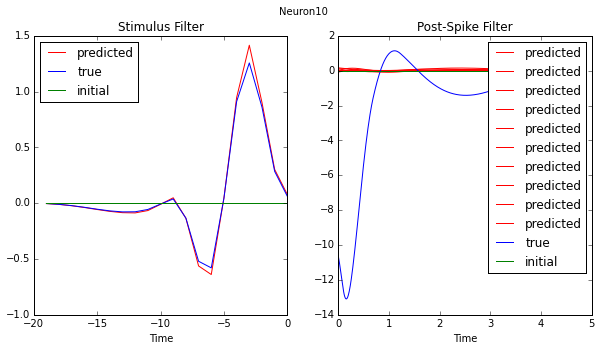

In [70]:
nofCells = N
for i in range(len(res_list)):
    k_coeff_predicted = res_list[i].x[:10]
    h_coeff_predicted = np.reshape(res_list[i].x[10:-1],(H.shape[1],nofCells),order = 'F')
    print('Estimated dc for neuron '+str(i)+': '+str(res_list[i].x[-1]))
    fig,axs = plt.subplots(1,2,figsize = (10,5))
    fig.suptitle('Neuron%d'%(i+1))
    axs[0].plot(-kt_domain[::-1],np.dot(K,k_coeff_predicted),'r',label = 'predicted')
    axs[0].set_title('Stimulus Filter')
    axs[0].hold(True)
    axs[0].plot(-kt_domain[::-1],np.dot(K,k_coeff),'b',label = 'true')
    axs[0].plot(-kt_domain[::-1],np.dot(K,pars0[:10]),'g',label = 'initial')
    axs[0].set_xlabel('Time')
    axs[0].legend(loc = 'upper left')
    axs[1].plot(ht_domain,np.dot(H_orth,h_coeff_predicted),'r',label = 'predicted')
    axs[1].plot(ht_domain,np.dot(H,h_coeff),'b',label = 'true')
    axs[1].plot(ht_domain,np.dot(H_orth,pars0[10+H_orth.shape[1]*i:10+(i+1)*H_orth.shape[1]]),'g',label = 'initial')
    axs[1].set_title('Post-Spike Filter')
    axs[1].set_xlabel('Time')
    axs[1].legend(loc = 'upper right')

In [71]:
# Add an interactive way to change the bases

In [72]:
# Add an easy way to change the coefficients: sample from some distribution